## Modeling of bank failures by FDIC 



In [2]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

sys.path.append("..")

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.22.2.post1


In [5]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [6]:
df_train = pd.read_hdf('../readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('../readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('../readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('../readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

FileNotFoundError: File ../readonly/df_train_FDIC_defaults_1Y.h5 does not exist

## Construct training and testing datasets for logistic regression

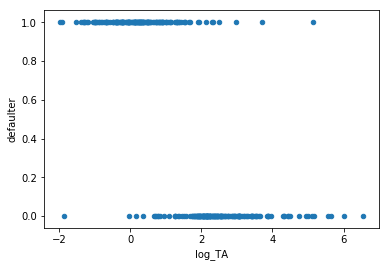

In [7]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

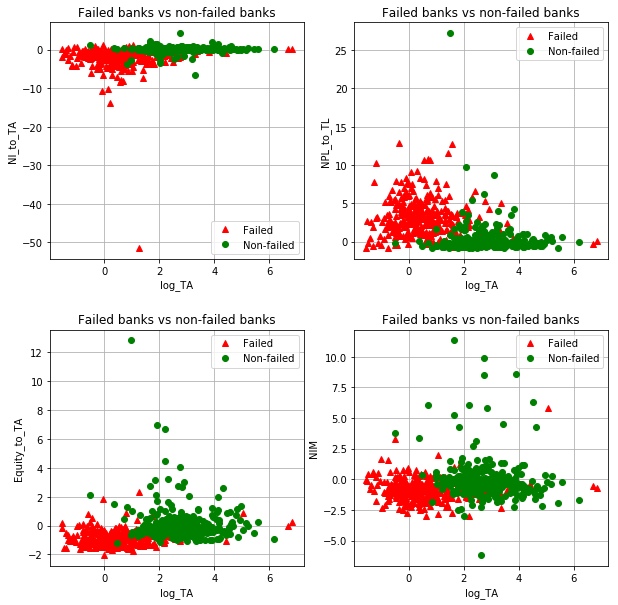

In [8]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [9]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [10]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 

    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [11]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Performed logistic regression using **cols_to_use** as predictors. Used df_train pandas DataFrame as training data set, and df_test pandas DataDrame as testing data set to perform prediction based on the already trained model. Utilized statsmodels package. The result of fitting logistic regression  assigned to variable named **model**

In [12]:
import statsmodels.api as sm
from sklearn import metrics

cols_to_use = state_cols + MEV_cols  + ['const']
model = None
df_train['const'] = 1


trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
model = sm.Logit(trY[:,0], trX).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.160607
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  641
Model:                          Logit   Df Residuals:                      622
Method:                           MLE   Df Model:                           18
Date:                Sat, 16 May 2020   Pseudo R-squ.:                  0.7681
Time:                        19:36:34   Log-Likelihood:                -102.95
converged:                       True   LL-Null:                       -444.03
                                        LLR p-value:                3.466e-133
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -1.6212      0.168     -9.678      0.000      -1.949      -1.293
x2            -0.2233      0.

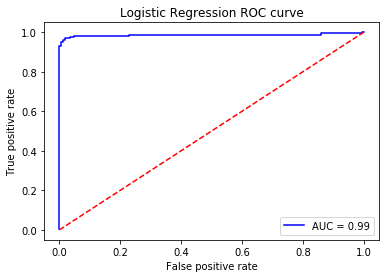

Accuracy score 0.966767
AUC score 0.986189
Kolmogorov-Smirnov statistic 0.951297


In [13]:
# prediction 
predicted_sm = np.array([])

predicted_sm = model.predict(teX) 



threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)
auc_score, accuracy_score, ks = calc_metrics(model, teX, df_test.defaulter)

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

# note that here teY[:,0] is the same as df_test.default_within_1Y

## Logistic Regression with sklearn

### Part 2 
In Part 2 scikit-learn is used to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, it is tested using teX, thisTeY and then logistic regression score is computed.

- Use **"l1"** penalty
- Inverse of regularization strength is set to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Tolerance is set to **1e-6**

In [15]:
from sklearn import neighbors, linear_model

trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.
thisTrY = trY[:,0]
thisTeY = teY[:,0]

logistic = None # instantiate a model and reference it
result = None # result of fitting the model

random_state = 42
logistic = linear_model.LogisticRegression(penalty='l1',tol=1e-6, C=1000.0)
result = logistic.fit(trX, thisTrY)
lr_score = logistic.score(teX, thisTeY)

print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.969789


**Notes:**
In this part scikit learn logistic regression will again be used but with different set of predictors. This will be a smaller set of predictor variables based on the analysis of P-values from the logistic regression. cols_to_use is used as predictors in df_train and df_test data sets. **defaulter** column is used as something to predict.

Reference to the logistic regression model **logistic** is initialized with an instance of appropriate class from  scikit learn module and let **result** be the result of fitting the model to the training data set.

The model is initialized with the following parameters:
- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [17]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ] + ['term_spread', 'stock_mkt_growth']

lr_score = 0.
logistic = None
result = None

# .... when initializing logistic regression class in 'sklearn', set random_state to 42 like this: random_state=42
random_state = 42
logistic = linear_model.LogisticRegression(penalty='l1',tol=1e-6, C=1000.0)
result = logistic.fit(df_train[cols_to_use], df_train.defaulter)
lr_score = logistic.score(df_test[cols_to_use], df_test.defaulter)

# combine results of the Logistic Regression to a small dataframe df_coeffs_LR
df_coeffs_LR = pd.DataFrame({0: np.array([0.] * (len(cols_to_use) + 1), dtype=np.float32)})
if logistic is not None:
    model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
    df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
    df_coeffs_LR

## Logistic Regression with Tensorflow

In [19]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [20]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [21]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [22]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [23]:
import tensorflow as tf

# define the model
reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)

# build Logistic Regression model using Tensorflow

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")


logits = tf.matmul(X, theta)
# y_proba = 1 / (1 + tf.exp(-logits)) # = 1 / (1 + tf.exp(-logits)) = sigmoid ativation
y_proba = tf.sigmoid(logits)

epsilon = 1e-7
loss = tf.losses.log_loss(y, y_proba, epsilon=epsilon)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)


# uses epsilon = 1e-7 by default to regularize the log function


init = tf.global_variables_initializer()


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [25]:
n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:
    sess.run(init)

    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_trainTf, y_trainTf, batch_size)
            sess.run([optimizer, loss], feed_dict={X: X_batch,
                                                 y: y_batch})
    y_proba_val = sess.run(y_proba, feed_dict={X: X_testTf})

In [26]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

149


In [27]:
y_pred.squeeze()

array([ True, False, False,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
       False, False,

precision:  0.979865771812
recall:  0.906832298137
AUC score =  0.982243332115
roc_auc =  0.982243332115
KS_test =  0.927438801608


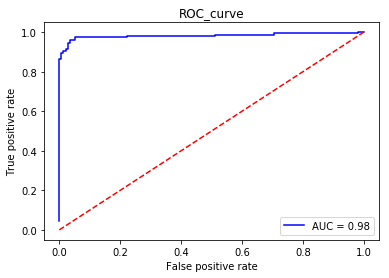

In [28]:
# evaluate precision, recall, and AUC

auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass

## Neural Network with Tensorflow

In [30]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [31]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Neural Network Construction

**Details:**
A Neural Network is implemented with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
neuron_layer() is used as a function to construct neural network layers.

- ReLU activation is used function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Sparse softmax cross-entropy is used with logits as a loss function

In [34]:
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")


with tf.name_scope("logr"):
    hidden1 = neuron_layer(X, n_hidden1, "hidden1", tf.nn.relu)
    hidden2 = neuron_layer(hidden1, n_hidden2, "hidden2", tf.nn.relu)
    logits = neuron_layer(hidden2, n_outputs, "outputs")
    
with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
    loss = tf.reduce_mean(xentropy, name="loss")
    
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))


init = tf.global_variables_initializer()

### Train Neural Network

**Details:**
A neural network is trained by passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, accuracy is evaluated using **X_testTf**, **y_testTf**


In [35]:
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable


with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_batch, y_batch = random_batch(X_trainTf, y_trainTf, batch_size)
            sess.run(training_op, feed_dict={X: X_batch,
                                                 y: y_batch})
#     _, loss, logits = sess.run([optimizer, loss], feed_dict={X: X_testTf,
#                                                             y: y_testTf})
    
    acc_test = accuracy.eval(feed_dict={X: X_testTf,
                                        y: y_testTf}) 
